In [60]:
from autogluon.tabular import TabularDataset, TabularPredictor
from ray import tune
import numpy as np
import math

In [61]:
#import data from Data/phil_socdata_train.csv, normalize (between 0 and 1) and standardize
train_data = TabularDataset('Data/phil_socdata_train.csv')
#train_data = train_data.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))) #normalize 
#train_data = train_data.apply(lambda x: (x - np.mean(x)) / np.std(x)) #standardize
train_data.head()


Loaded data from: Data/phil_socdata_train.csv | Columns = 4 / 4 | Rows = 427326 -> 427326


,SOC,V,I,T
0,100.000031,400.125,-1.50,16.5
1,100.000031,400.125,-1.56,16.5
2,100.000031,400.125,-1.62,16.5
3,100.000031,400.125,-1.68,16.5
4,100.000031,400.125,-1.74,16.5


In [62]:
#train_data = TabularDataset(f'Data/phil_socdata_train.csv')
#train_data.head()

In [63]:
label = 'SOC'
train_data[label].describe()

count    427326.000000
mean         67.759531
std          24.669208
min           0.000000
25%          48.627468
50%          72.941200
75%          88.627480
max         100.000031
Name: SOC, dtype: float64

In [70]:
#predictor = TabularPredictor(label=label,eval_metric='root_mean_squared_error').fit(train_data, presets='best_quality',time_limit = 30)


import autogluon.core as ag

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 1000,  # number of training epochs (controls training time of NN models)
    #'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    #'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    #'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    #'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

time_limit = 60  # train various models for ~10 min
num_trials = 50  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    #'num_trials': num_trials,
    #'scheduler' : 'local',
    'searcher': "bayes",
}



predictor = TabularPredictor(label=label).fit(
    train_data, 
    #time_limit=time_limit, 
    presets='best_quality',
    #hyperparameters=hyperparameters, 
    #refit_full=True,set_best_to_refit_full=True,
    auto_stack=True,
    #save_space=True,
    #hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
    #hyperparameters='very_light',
    ag_args_fit={'num_gpus': 1}
)



No path specified. Models will be saved in: "AutogluonModels/ag-20230402_004030/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/ag-20230402_004030/"
AutoGluon Version:  0.7.0
Python Version:     3.10.8
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #148-Ubuntu SMP Mon Oct 17 16:02:06 UTC 2022
Train Data Rows:    427326
Train Data Columns: 3
Label Column: SOC
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (100.000030517578, 0.0, 67.75953, 24.66921)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'r

In [71]:
# import test data from Data/phil_socdata_test.csv, normalize (between 0 and 1) and standardize
test_data = TabularDataset(f'Data/phil_socdata_test.csv')
#test_data = test_data.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))) #normalize
#test_data = test_data.apply(lambda x: (x - np.mean(x)) / np.std(x)) #standardize

y_pred = predictor.predict(test_data.drop(columns=[label]))
y_pred.head()

Loaded data from: Data/phil_socdata_test.csv | Columns = 4 / 4 | Rows = 18307 -> 18307


0    95.287987
1    95.287987
2    95.287987
3    95.287987
4    95.287987
Name: SOC, dtype: float32

In [72]:
predictor.evaluate(test_data, silent=True)

/home/witvoetk/anaconda3/envs/tf/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'root_mean_squared_error': -3.7095613334033684,
 'mean_squared_error': -13.760845286281375,
 'mean_absolute_error': -3.0074101844579157,
 'r2': 0.9787186361433052,
 'pearsonr': 0.9928085322772369,
 'median_absolute_error': -2.74522400298828}

In [73]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge_BAG_L1,-3.709561,-3.234755,0.528319,20.041728,30.359292,0.528319,20.041728,30.359292,1,True,1
1,WeightedEnsemble_L2,-3.709561,-3.234755,0.530197,20.047119,30.368017,0.001878,0.005391,0.008726,2,True,2


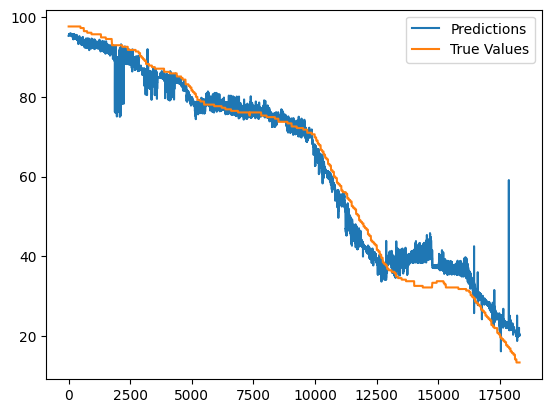

In [74]:
#plots the predicted vs actual values of the top performing model using matplotlib
import matplotlib.pyplot as plt
plt.plot(y_pred, label="Predictions")
plt.plot(test_data[label], label="True Values")
plt.legend()
plt.show()

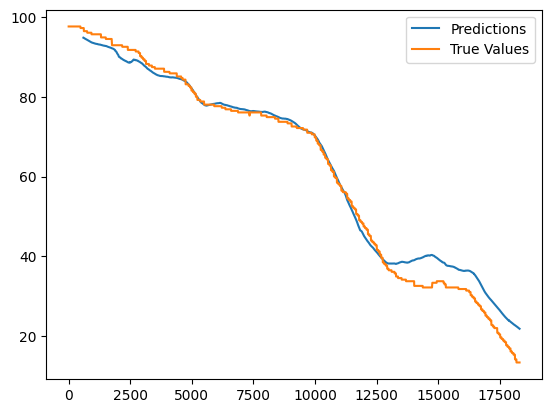

In [75]:
#smooths the predicted values using a moving average of 100 values and plots them against the actual values
y_pred_smooth = y_pred.rolling(600).mean()
plt.plot(y_pred_smooth, label="Predictions")
plt.plot(test_data[label], label="True Values")
plt.legend()
plt.show()

In [76]:
mse_test = np.mean(((y_pred - test_data[label])**2))
rmse_test = math.sqrt(mse_test)
print("test data rmse", rmse_test)

test data rmse 3.7095613334033684


In [77]:
#rmse test of smoothed data
mse_test = np.mean(((y_pred_smooth - test_data[label])**2))
rmse_test = math.sqrt(mse_test)
print("test data rmse", rmse_test)

test data rmse 3.4204423061511466


In [78]:
predictor.feature_importance(test_data)

Computing feature importance via permutation shuffling for 3 features using 5000 rows with 5 shuffle sets...
	6.49s	= Expected runtime (1.3s per shuffle set)
	3.72s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
V,31.755675,0.233812,3.526373e-10,5,32.237096,31.274254
I,4.729630,0.146385,1.099767e-07,5,5.031038,4.428222
T,0.682845,0.021464,1.169869e-07,5,0.727039,0.638651


In [79]:
#calculates the accuracy in percent of the smoothed predictions and normal predictions
accuracy = 0
accuracy_smooth = 0
for i in range(len(y_pred)):
    if abs(y_pred[i] - test_data[label][i]) < 0.1:
        accuracy += 1
    if abs(y_pred_smooth[i] - test_data[label][i]) < 0.1:
        accuracy_smooth += 1

print("accuracy", accuracy/len(y_pred)) #accuracy of normal predictions in percent
print("accuracy_smooth", accuracy_smooth/len(y_pred_smooth))

accuracy 0.017315780848855628
accuracy_smooth 0.03408532255421424
